# Предсказание выхода золота из золотосодержащей руды
# Описание проекта

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

# Описание данных
Путь к файлам:
    
    /datasets/gold_recovery_train.csv — обучающая выборка;
	/datasets/gold_recovery_test.csv — тестовая выборка;
	/datasets/gold_recovery_full.csv — исходные данные.
    
    
Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи.

## Наименование признаков
[этап].[тип_параметра].[название_параметра]

Возможные значения для блока [этап]:
	
    rougher — флотация
	primary_cleaner — первичная очистка
	secondary_cleaner — вторичная очистка
	final — финальные характеристики

Возможные значения для блока [тип_параметра]:
	
    input — параметры сырья
	output — параметры продукта
	state — параметры, характеризующие текущее состояние этапа
	calculation — расчётные характеристики
    



Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.

Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.

Порядок выполнения проекта

1. Подготовить данные

    1.1. Открыть файлы и изучить их.
    
    1.2. Проверить, что эффективность обогащения рассчитана правильно. Вычислить её на обучающей выборке для признака rougher.output.recovery. Найти MAE между вашими расчётами и значением признака. Описать выводы.
    
    1.3. Проанализировать признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?
    
    1.4. Провести предобработку данных.

2. Проанализировать данные
    
    2.1. Посмотреть, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Описать выводы.
    
    2.2. Сравнить распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.
    
    2.3. Исследовать суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Были замечены аномальные значения в суммарном распределении или нет? Если они есть, стоит ли их удалять из обеих выборок? Описать выводы и удалить аномалии.

3. Построить модель

    3.1. Написать функцию для вычисления итоговой sMAPE.
    
    3.2. Обучить разные модели и оценить их качество кросс-валидацией. Выбрать лучшую модель и проверить её на тестовой выборке. Описать выводы.

# 1. Подготовка данных

In [1]:
#1
import pandas as pd
from sklearn.metrics import mean_absolute_error

#2 
import matplotlib.pyplot as plt

import numpy as np
from scipy import stats as st
from numpy.random import RandomState

#3
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn import linear_model

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.dummy import DummyClassifier

In [2]:
#округляем значения до тысячных при отображении в выводе дробных чисел
pd.options.display.float_format = '{:,.3f}'.format

## 1.1. Открыть файлы и изучить их

In [3]:
train = pd.read_csv('/datasets/gold_recovery_train.csv')
test = pd.read_csv('/datasets/gold_recovery_test.csv')
full = pd.read_csv('/datasets/gold_recovery_full.csv')

In [4]:
train.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055,9.890,5.507,42.192,70.541,10.412,0.895,16.904,2.143,...,14.017,-502.488,12.100,-504.716,9.926,-498.310,8.080,-500.471,14.151,-605.842
1,2016-01-15 01:00:00,6.029,9.969,5.258,42.702,69.266,10.463,0.927,16.635,2.225,...,13.992,-505.503,11.951,-501.332,10.039,-500.170,7.985,-500.582,13.998,-599.787
2,2016-01-15 02:00:00,6.056,10.214,5.384,42.658,68.116,10.507,0.954,16.209,2.258,...,14.015,-502.521,11.913,-501.133,10.071,-500.129,8.014,-500.518,14.029,-601.427
3,2016-01-15 03:00:00,6.048,9.977,4.859,42.690,68.348,10.423,0.884,16.533,2.147,...,14.037,-500.857,12.000,-501.194,9.970,-499.202,7.977,-500.256,14.006,-599.996
4,2016-01-15 04:00:00,6.149,10.143,4.939,42.774,66.927,10.360,0.793,16.526,2.055,...,14.027,-499.839,11.953,-501.054,9.926,-501.687,7.894,-500.356,13.997,-601.497


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

In [7]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


In [8]:
print('Количество дубликатов строк train:', train.duplicated().sum())
print('Количество дубликатов строк test:', test.duplicated().sum())
print('Количество дубликатов строк full:', full.duplicated().sum())

Количество дубликатов строк train: 0
Количество дубликатов строк test: 0
Количество дубликатов строк full: 0


In [9]:
print('Количество дубликатов в поле date - train:', train['date'].duplicated().sum())
print('Количество дубликатов в поле date - test:', test['date'].duplicated().sum())
print('Количество дубликатов в поле date - full:', full['date'].duplicated().sum())

Количество дубликатов в поле date - train: 0
Количество дубликатов в поле date - test: 0
Количество дубликатов в поле date - full: 0


* Данные содержат пропуски (необходимо заполнить пропуски или удалить строки).
* Данные не содержат дубликаты строк, значения в поле date не повторяются для каждой выборки.
* Признаки количественные, содержат положительные и отрицательные значения, порядок значений сильно разнится (единицы - десятки - сотни. Необходимо провести масштабирование признаков).

## 1.2. Проверить, что эффективность обогащения рассчитана правильно. Вычислить её на обучающей выборке для признака rougher.output.recovery. Найти MAE между собственными расчётами и значением признака. Описать выводы

###  Вычислить эффективность обогащения на обучающей выборке для признака rougher.output.recovery
Для расчёта возьмём только те строки, где значения входных параметров и целевых признаков не содержат пропуски.

In [4]:
c = train['rougher.output.concentrate_au'][train['rougher.output.concentrate_au'].notna() & train['rougher.output.tail_au'].notna()]
f = train['rougher.input.feed_au'][train['rougher.input.feed_au'].notna() & train['rougher.output.tail_au'].notna()]
t = train['rougher.output.tail_au'][train['rougher.output.recovery'].notna() & train['rougher.output.tail_au'].notna()]
train['recovery'] = (c * (f - t))/(f * (c - t)) * 100

Посмотрим на графическое представление распределения.

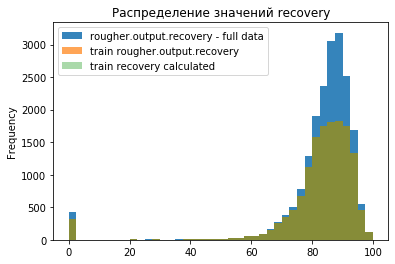

In [11]:
full['rougher.output.recovery'].plot(kind='hist', bins=40, alpha=0.9, title='Распределение значений recovery', legend=True, label='rougher.output.recovery - full data')
train['rougher.output.recovery'].plot(kind='hist', bins=40, alpha=0.7, legend=True, label='train rougher.output.recovery')
train['recovery'].plot(kind='hist', bins=40, alpha=0.4, legend=True, label='train recovery calculated')
plt.show()

### Найти MAE между собственными расчётами и значением признака 

In [12]:
print('MAE признака "эффективность обогащения" для этапа флотации: {:.16f}'.\
      format(mean_absolute_error(train['recovery'][train['rougher.output.recovery'].notna()], \
                                 train['rougher.output.recovery'][train['rougher.output.recovery'].notna()])))

MAE признака "эффективность обогащения" для этапа флотации: 0.0000000000000094


### Описать выводы (проверить, что эффективность обогащения рассчитана правильно.)

Значение MAE близко к нулю, однако, не равно ему, значит, в данных есть расхождения. Возможно, большие ошибки компенсируются маленькими. 

На гистограмме выше видим, что значения целевого признака и расчитанные самостоятельно значения совпадают.

Если эти значения целевого признака были предсказаны, значит модель, которая их "выдала" достаточно точная.

## 1.3. Проанализировать признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся? 

В тестовой выборке недоступны параметры 2 типов: output и calculation - параметры, получаемые на выходе.  Output -  результат этапа технологического процесса, calculation - результат вычислений. 

Значения этих параметров автоматически фиксируются датчиками, предугадываются или расчитываются.

Для этапа "флотация":
    
    output:
    
        rougher.output.concentrate_ag
        rougher.output.concentrate_pb
        rougher.output.concentrate_sol
        rougher.output.concentrate_au
        rougher.output.recovery
        rougher.output.tail_ag
        rougher.output.tail_pb
        rougher.output.tail_sol
        rougher.output.tail_au

    calculation:
    
        rougher.calculation.sulfate_to_au_concentrate
        rougher.calculation.floatbank10_sulfate_to_au_feed
        rougher.calculation.floatbank11_sulfate_to_au_feed
        rougher.calculation.au_pb_ratio
        
Для этапа "первичная очистка":

    primary_cleaner.output.concentrate_ag
    primary_cleaner.output.concentrate_pb
    primary_cleaner.output.concentrate_sol
    primary_cleaner.output.concentrate_au
    primary_cleaner.output.tail_ag
    primary_cleaner.output.tail_pb
    primary_cleaner.output.tail_sol
    primary_cleaner.output.tail_au

Для этапа "вторичная очистка":

    secondary_cleaner.output.tail_ag
    secondary_cleaner.output.tail_pb
    secondary_cleaner.output.tail_sol
    secondary_cleaner.output.tail_au

Для этапа "финальные характеристики":

    final.output.concentrate_ag
    final.output.concentrate_pb
    final.output.concentrate_sol
    final.output.concentrate_au
    final.output.recovery
    final.output.tail_ag
    final.output.tail_pb
    final.output.tail_sol
    final.output.tail_au 

Выведем признаки, недоступные на тестовой выборке. Отображаем признаки тестовой выборки, которые не входят в обучающую, и исключаем рассчитанный ранее признак "recovery". В качестве альтернативного варианта вместо обучающей выборки можно взять полную, чтобы не ограничивать список признаков дополнительно.

In [5]:
test_cols = test.columns
train_cols = train.columns
train_cols[(~train_cols.isin(test_cols)) & (train_cols!='recovery')]

Index(['final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.au_pb_ratio', 'rougher.output.concentrate_ag',
       'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
       'rougher.output.concentrate_au', 'rougher.outpu

## 1.4. Провести предобработку данных
### Добавление целевых признаков в тестовую выборку

Нам по условию задачи переданы три набора данных. Полный набор, обучающий и тестовый. В тестовом наборе содержатся только те признаки, на основании которых можно сделать прогноз. Значения целевых признаков там не содержатся (rougher.output.recovery и final.output.recovery). 

Для того, чтобы правильно оценить работу модели на предоставленной тестовой выборке, необходимо дополнить её целевыми признаками.

In [6]:
test = pd.merge(test, full[['date', 'rougher.output.recovery', 'final.output.recovery']], left_index = False, \
                      right_index = False, left_on='date', right_on = 'date', \
                      how='inner')
test.shape

(5856, 55)

### Обработка пропусков

In [15]:
full.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,"22,627.000","22,629.000","22,331.000","22,630.000","20,753.000","22,633.000","22,516.000","22,445.000","22,635.000","21,107.000",...,"22,571.000","22,587.000","22,608.000","22,607.000","22,615.000","22,615.000","22,615.000","22,616.000","22,597.000","22,615.000"
mean,4.782,9.095,8.640,40.001,67.447,8.924,2.488,9.524,2.827,140.278,...,18.205,-499.879,14.356,-476.533,14.883,-503.323,11.627,-500.522,17.977,-519.361
std,2.030,3.231,3.785,13.398,11.616,3.518,1.189,4.080,1.263,49.919,...,6.561,80.274,5.656,93.823,6.373,72.926,5.757,78.956,6.636,75.477
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,-799.921,0.000,-800.837,-0.423,-799.741,0.427,-800.258,-0.079,-810.474
25%,4.019,8.750,7.117,42.384,63.282,7.684,1.805,8.144,2.303,110.177,...,14.096,-500.896,10.883,-500.309,10.941,-500.629,8.038,-500.168,13.968,-500.982
50%,4.954,9.915,8.909,44.653,68.322,9.484,2.653,10.213,2.914,141.331,...,18.007,-499.917,14.948,-499.612,14.859,-499.865,10.990,-499.952,18.004,-500.095
75%,5.863,10.930,10.706,46.112,72.951,11.085,3.288,11.861,3.555,174.050,...,22.998,-498.362,17.978,-400.224,18.015,-498.489,14.001,-499.492,23.010,-499.526
max,16.002,17.032,19.616,53.611,100.000,19.552,6.087,22.862,9.790,274.410,...,60.000,-127.692,31.270,-6.507,63.116,-244.484,39.846,-120.191,54.877,-29.094


В исходных данных есть пропущенные значения почти практически для всех признаков, независимо от стадии процесса. Так как технологический процесс подразумевает автоматическую регистрацию значений параметров, скорее всего, произошёл сбой, не позволивший получить данные. 

Заполнять пропуски средними значениями не будем, так как не знаем реальных зависимостей параметров, и искажённые параметры на входе дадут неверный результат на выходе.

Нас также особенно интересуют рассчитываемый признаки recovery, в которых не должно быть пропусков, иначе не получится провести оценку качества работы моделей. 

Принимаем решение удалить наблюдения с пропуенными recovery, а прочие пропущенные значения заполнить нулями.

In [7]:
#train
print('train до удаления:', train.shape)
train = train[train['final.output.recovery'].notna()]
train = train[train['rougher.output.recovery'].notna()]
print('train после удаления:', train.shape)
train = train.dropna().reset_index(drop=True)

#test
print('test до удаления:', test.shape)
test = test[test['final.output.recovery'].notna()]
test = test[test['rougher.output.recovery'].notna()]
print('test после удаления:', test.shape)
test = test.dropna().reset_index(drop=True)

#full
print('full до удаления:', full.shape)
full = full[full['final.output.recovery'].notna()]
full = full[full['rougher.output.recovery'].notna()]
print('full после удаления:', full.shape)
full = full.dropna().reset_index(drop=True)

train до удаления: (16860, 88)
train после удаления: (14149, 88)
test до удаления: (5856, 55)
test после удаления: (5290, 55)
full до удаления: (22716, 87)
full после удаления: (19439, 87)


In [8]:
train = train.fillna(0)
test = test.fillna(0)
full = full.fillna(0)

# Вывод

По условию задачи получены три набора данных: полный набор, обучающий и тестовый. 

В тестовой выборке недоступны параметры 2 типов: output и calculation - параметры, получаемые на выходе. Output - результат этапа технологического процесса, calculation - результат вычислений.
Значения этих параметров автоматически фиксируются датчиками, предугадываются или расчитываются.

В тестовом наборе содержатся только те признаки, на основании которых можно сделать прогноз. Значения целевых признаков (rougher.output.recovery и final.output.recovery) были добавлены в тестовую выборку для возможности оценки эффективности работы модели машинного обучения по предлагаемой метрике sMAPE.

Данные содержали пропуски. Наблюдения с пропуенными значениями recovery, а прочие пропущенные значения заполнены нулями. 

Признаки количественные, содержат положительные и отрицательные значения, порядок значений сильно разнится (единицы - десятки - сотни). Далее при подготовке признаков для обучения моделей необходимо будет провести масштабирование признаков.


Значение MAE близко к нулю, однако, не равно ему, значит, в данных есть расхождения. Возможно, большие ошибки компенсируются маленькими.

# 2. Анализ данных

## 2.1. Посмотреть, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Описать выводы

Стадии, которые рассматриваются: 
    
    1 - флотация.вход 
    2 - флотация.выход 
    3 - первичная_очистка.выход 
    4 - финальные_характеристики.выход.


In [18]:
full['rougher.input.feed_au'].describe()

count   16,094.000
mean         8.517
std          1.828
min          0.010
25%          7.080
50%          8.367
75%          9.940
max         13.731
Name: rougher.input.feed_au, dtype: float64

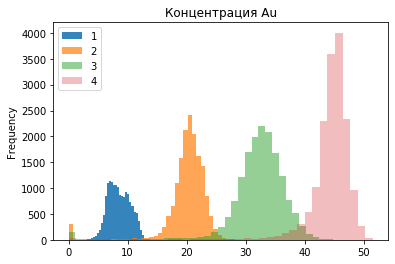

In [19]:
full['rougher.input.feed_au'].plot(kind='hist', bins=40, alpha=0.9, title='Концентрация Au', legend=True, label='1')
full['rougher.output.concentrate_au'].plot(kind='hist', bins=40, alpha=0.7, legend=True, label='2')
full['primary_cleaner.output.concentrate_au'].plot(kind='hist', bins=40, alpha=0.5, legend=True, label='3')
full['final.output.concentrate_au'].plot(kind='hist', bins=40, alpha=0.3, legend=True, label='4')
plt.show()

In [20]:
full[['rougher.input.feed_au', 'rougher.output.concentrate_au', \
      'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au']].describe()

,rougher.input.feed_au,rougher.output.concentrate_au,primary_cleaner.output.concentrate_au,final.output.concentrate_au
count,"16,094.000","16,094.000","16,094.000","16,094.000"
mean,8.517,20.052,32.066,44.307
std,1.828,3.621,5.206,4.210
min,0.010,0.000,0.000,0.000
25%,7.080,19.143,30.300,43.431
50%,8.367,20.507,32.644,44.986
75%,9.940,21.917,34.829,46.254
max,13.731,28.825,45.934,51.572


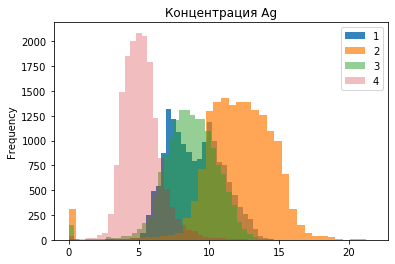

In [21]:
full['rougher.input.feed_ag'].plot(kind='hist', bins=40, alpha=0.9, title='Концентрация Ag', legend=True, label='1')
full['rougher.output.concentrate_ag'].plot(kind='hist', bins=40, alpha=0.7, legend=True, label='2')
full['primary_cleaner.output.concentrate_ag'].plot(kind='hist', bins=40, alpha=0.5, legend=True, label='3')
full['final.output.concentrate_ag'].plot(kind='hist', bins=40, alpha=0.3, legend=True, label='4')
plt.show()

In [22]:
full[['rougher.input.feed_ag', 'rougher.output.concentrate_ag', \
      'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag']].describe()

,rougher.input.feed_ag,rougher.output.concentrate_ag,primary_cleaner.output.concentrate_ag,final.output.concentrate_ag
count,"16,094.000","16,094.000","16,094.000","16,094.000"
mean,8.985,12.085,8.675,5.191
std,1.910,2.698,1.945,1.333
min,0.010,0.000,0.000,0.000
25%,7.427,10.664,7.531,4.278
50%,8.882,12.232,8.723,5.084
75%,10.398,13.835,9.956,5.894
max,14.596,21.726,15.006,16.002


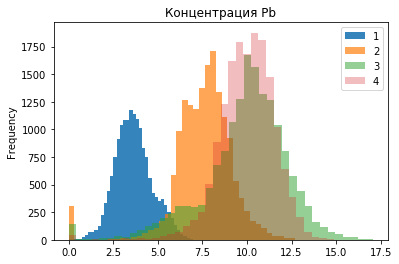

In [23]:
full['rougher.input.feed_pb'].plot(kind='hist', bins=40, alpha=0.9, title='Концентрация Pb', legend=True, label='1')
full['rougher.output.concentrate_pb'].plot(kind='hist', bins=40, alpha=0.7, legend=True, label='2')
full['primary_cleaner.output.concentrate_pb'].plot(kind='hist', bins=40, alpha=0.5, legend=True, label='3')
full['final.output.concentrate_pb'].plot(kind='hist', bins=40, alpha=0.3, legend=True, label='4')
plt.show()

In [24]:
full[['rougher.input.feed_pb', 'rougher.output.concentrate_pb', \
      'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']].describe()

,rougher.input.feed_pb,rougher.output.concentrate_pb,primary_cleaner.output.concentrate_pb,final.output.concentrate_pb
count,"16,094.000","16,094.000","16,094.000","16,094.000"
mean,3.637,7.553,9.884,9.998
std,1.042,1.688,2.402,1.569
min,0.010,0.000,0.000,0.000
25%,2.928,6.697,8.823,9.103
50%,3.573,7.698,10.183,10.092
75%,4.272,8.511,11.399,11.031
max,7.143,12.702,17.081,17.032


Концентрация золота в руде постепенно увеличивается на каждом этапе процесса (от 8.5 до 44.3 в среднем).

Концентрация серебра в руде увеличивается после флотации, однако, на следующи этапах постепенно падает.

Концентрация свинца в руде увеличивается по этапам (от 3.6 до 10 в среднем). После вторичной очистки концентрация увеличилась незначительно. 

На всех этапах кроме подачи есть небольшие пики нулевых значений по всем трём металлам.

## 2.2. Сравнить распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной

Проверим гипотезу о том, что среднее одинаковое.

Для проверки гипотезы используем критерий Стьюдента - специальный случай двухвыборочных критериев согласия. Проверяется гипотеза сдвига, согласно которой распределения двух выборок имеют одинаковую форму и отличаются только сдвигом на константу.

Т.к. при формулировании нулевой гипотезы всегда предполагается использование знака равенства, сформулируем следующим образом:

*Средний размер гранул в обучающей выборке равен среднему размеру гранул в тестовой выборке*.

Альтернативная гипотеза:

*Средний размер гранул в обучающей выборке отличается от среднего размера гранул в тестовой выборке*.


Возьмём уровень значимости 5%.

In [25]:
alpha = 0.05 # критический уровень статистической значимости
            # если p-value окажется меньше него - отвергнем гипотезу

feed_size_train = train['rougher.input.feed_size']
feed_size_test = test['rougher.input.feed_size']
    
ttest_results = st.ttest_ind(
    feed_size_train, 
    feed_size_test)

print('p-значение:', ttest_results.pvalue)

if (ttest_results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 2.111721458160281e-05
Отвергаем нулевую гипотезу


Размер гранул сырья отличается.

Посмотрим основные параметры распределения.

---------------
Размер гранул в обучающей выборке


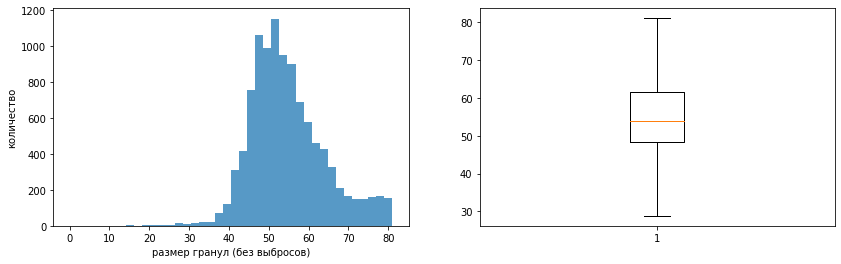

---------------
Размер гранул в тестовой выборке


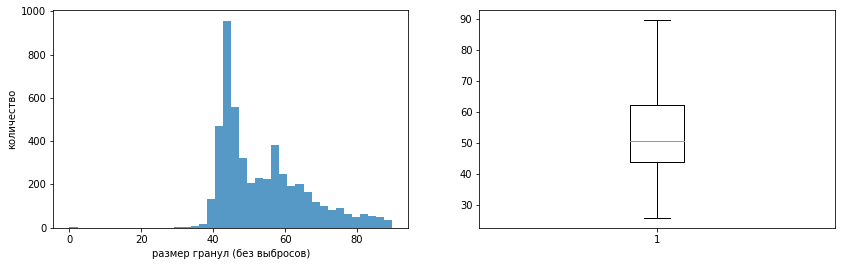

,min,min_norm,lower_mean,mean,upper_mean,max_norm,max,std
0,9.660,0,56.892,57.215,57.579,81.059,484.967,18.913
1,0.046,0,55.374,55.864,56.365,89.796,392.494,18.915


In [26]:
selection = [train['rougher.input.feed_size'], test['rougher.input.feed_size']]

state = 28
rnd_state = RandomState(28)

mean_result = pd.DataFrame(columns=['min', 'min_norm', 'lower_mean', 'mean', 'upper_mean', 'max_norm', 'max', 'std'])


n = 0
for select in selection:
        print('---------------')
        if n==0:
            print('Размер гранул в обучающей выборке')
        else:
            print('Размер гранул в тестовой выборке')
        q3 = select.quantile(0.75)
        q1 = select.quantile(0.25)
        iqr = q3 - q1
        if (iqr * 1.5 - q1) < 0:
            min_norm = 0
        else: 
            min_norm = (q1 - iqr*1.5)
        max_norm = iqr*1.5 + q3
             
        fig, (ax1, ax2) = plt.subplots(
        nrows=1, ncols=2,
        figsize=(14, 4)
        )
        
        ax1.hist(select, bins=(40), alpha=0.75, range=(min_norm, max_norm))
        ax1.set_xlabel('размер гранул (без выбросов)')
        ax1.set_ylabel('количество')

        ax2.boxplot(select, showfliers=False)
        plt.show()
        
        values = []
        for i in range(1000):
            values.append(select.sample(frac = 0.5, random_state = rnd_state, replace=False, axis = 0).mean())


        values = pd.Series(values)

        sample_mean = values.mean()

        lower = values.quantile(0.025)
        upper = values.quantile(0.975)

        mean_result.loc[n, 'lower_mean'] = lower
        mean_result.loc[n, 'upper_mean'] = upper
        mean_result.loc[n, 'mean'] = select.mean()
        mean_result.loc[n, 'std'] = select.describe()[2]
        mean_result.loc[n, 'min'] = select.describe()[3]
        mean_result.loc[n, 'max'] = select.describe()[7]
        mean_result.loc[n, 'min_norm'] = min_norm
        mean_result.loc[n, 'max_norm'] = max_norm
        
     
        n += 1
        
mean_result

95% доверительный интервал для среднего обучающей выборки: 56.892-57.579, для тестовой: 55.374-56.365. При этом стандартное отклонение для обоих выборок почти одинаковое.

На графиках видны различия в распределении значений: в тестовой выборке есть пик значений в районе 45, в обучающей - в районе 50.

## 2.3. Исследовать суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Есть ли аномальные значения в суммарном распределении или нет? Если они есть, стоит ли их удалять из обеих выборок? Описать выводы и удалить аномалии

In [9]:
def concentration():
    train_floatation = train['rougher.input.feed_ag'] + train['rougher.input.feed_au'] + \
    train['rougher.input.feed_pb'] + train['rougher.input.feed_sol']
    full_floatation = full['rougher.input.feed_ag'] + full['rougher.input.feed_au'] + \
    full['rougher.input.feed_pb'] + full['rougher.input.feed_sol']

    train_floatation_out = train['rougher.output.concentrate_ag'] + train['rougher.output.concentrate_au'] + \
    train['rougher.output.concentrate_pb'] + train['rougher.output.concentrate_sol']
    full_floatation_out = full['rougher.output.concentrate_ag'] + full['rougher.output.concentrate_au'] + \
    full['rougher.output.concentrate_pb'] + full['rougher.output.concentrate_sol']

    train_pc_out = train['primary_cleaner.output.concentrate_ag'] + train['primary_cleaner.output.concentrate_au'] + \
    train['primary_cleaner.output.concentrate_pb'] + train['primary_cleaner.output.concentrate_sol']
    full_pc_out = full['primary_cleaner.output.concentrate_ag'] + full['primary_cleaner.output.concentrate_au'] + \
    full['primary_cleaner.output.concentrate_pb'] + full['primary_cleaner.output.concentrate_sol']

    train_final = train['final.output.concentrate_ag'] + train['final.output.concentrate_au'] + \
    train['final.output.concentrate_pb'] + train['final.output.concentrate_sol']
    full_final = full['final.output.concentrate_ag'] + full['final.output.concentrate_au'] + \
    full['final.output.concentrate_pb'] + full['final.output.concentrate_sol']

    data_train = [train_floatation, train_floatation_out, train_pc_out, train_final]
    data_full = [full_floatation, full_floatation_out, full_pc_out, full_final]

    ax = full_floatation.plot(kind='hist', bins=100, alpha = 0.8, grid=True, figsize=(10, 6), legend=True, label='1')
    full_floatation_out.plot(kind='hist', bins=100, alpha = 0.7, grid=True, figsize=(10, 6), legend=True, label='2')
    full_pc_out.plot(kind='hist', bins=100, alpha = 0.6, grid=True, figsize=(10, 6), legend=True, label='3')
    full_final.plot(kind='hist', bins=100, alpha = 0.5, grid=True, figsize=(10, 6), legend=True, label='4')

    ax.set_title('Суммарная концентрация веществ в обучающей выборке')
    ax.set_xlabel('Концентрация, %')
    ax.set_ylabel('Количество')
    plt.show()

    print('Полные данные')
    n=1
    for data in data_full:

        print('Этап', n, ' - Количество нулевых значений', data[data==0].count(), \
              ', % от общего {:.2%}'.format(data[data==0].count() / data.count()))
        n += 1

    print('Обучающая выборка')
    n=1
    for data in data_train:

        print('Этап', n, ' - Количество нулевых значений', data[data==0].count(), \
              ', % от общего {:.2%}'.format(data[data==0].count() / data.count()))
        n += 1

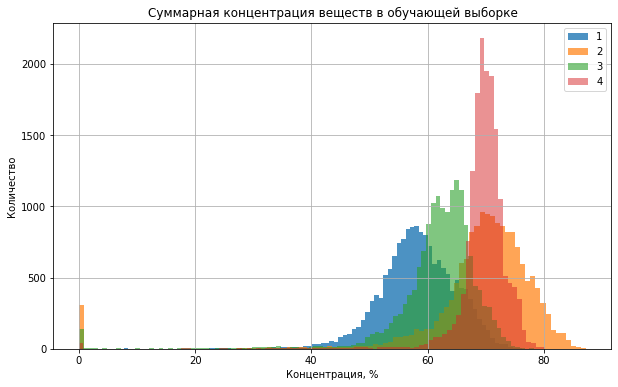

Полные данные
Этап 1  - Количество нулевых значений 0 , % от общего 0.00%
Этап 2  - Количество нулевых значений 301 , % от общего 1.87%
Этап 3  - Количество нулевых значений 78 , % от общего 0.48%
Этап 4  - Количество нулевых значений 41 , % от общего 0.25%
Обучающая выборка
Этап 1  - Количество нулевых значений 0 , % от общего 0.00%
Этап 2  - Количество нулевых значений 205 , % от общего 1.86%
Этап 3  - Количество нулевых значений 50 , % от общего 0.45%
Этап 4  - Количество нулевых значений 29 , % от общего 0.26%


In [28]:
concentration()

При прохождении всех стадий технологического процесса суммарная концентрация всех полезных веществ увеличивается и доходит в среднем до 60%.

На всех стадиях кроме первой есть определённое количество наблюдений, в котороых этот показатель равен нулю, значит, либо изначально в данных были нули, либо пропуски, которые были заполнены нулями. 

В полной выборке таких наблюдений больше (т.к. она включает в себя обучающую и тестовую выборки).

И тот, и другой вариант являются ошибками, т.к. система автоматического контроля размера гранул не сработала и не смогла определить размер гранул сырья.

Удалим из выборок (обучающей и полной) наблюдения с нулевой суммарной концентрацией сырья, чтобы они не отразились на работе модели машинного обучения.

In [10]:
print('train до удаления:', train.shape)

train = train[((train['rougher.output.concentrate_ag'] + train['rougher.output.concentrate_au'] + \
                train['rougher.output.concentrate_pb'] + train['rougher.output.concentrate_sol'])!=0) & \
                ((train['primary_cleaner.output.concentrate_ag'] + train['primary_cleaner.output.concentrate_au'] + \
                  train['primary_cleaner.output.concentrate_pb'] + train['primary_cleaner.output.concentrate_sol'])!=0) &
                ((train['final.output.concentrate_ag'] + train['final.output.concentrate_au'] + \
                  train['final.output.concentrate_pb'] + train['final.output.concentrate_sol'])!=0)]

print('full до удаления:', full.shape)
full = full[((full['rougher.output.concentrate_ag'] + full['rougher.output.concentrate_au'] + \
              full['rougher.output.concentrate_pb'] + full['rougher.output.concentrate_sol'])!=0) & \
            ((full['primary_cleaner.output.concentrate_ag'] + full['primary_cleaner.output.concentrate_au'] + \
              full['primary_cleaner.output.concentrate_pb'] + full['primary_cleaner.output.concentrate_sol'])!=0) & \
            ((full['final.output.concentrate_ag'] + full['final.output.concentrate_au'] + \
              full['final.output.concentrate_pb'] + full['final.output.concentrate_sol'])!=0)]

train = train.dropna().reset_index(drop=True)
full = full.dropna().reset_index(drop=True)
print('train после удаления:', train.shape)
print('full после удаления:', full.shape)

train до удаления: (11017, 88)
full до удаления: (16094, 87)
train после удаления: (10737, 88)
full после удаления: (15679, 87)


Посмотрим на график псле удаления аномальных значений.

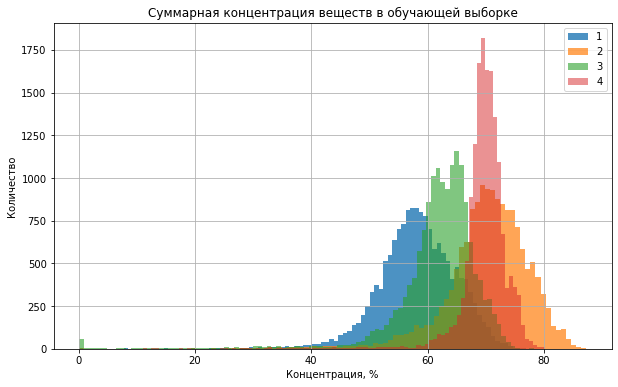

Полные данные
Этап 1  - Количество нулевых значений 0 , % от общего 0.00%
Этап 2  - Количество нулевых значений 0 , % от общего 0.00%
Этап 3  - Количество нулевых значений 0 , % от общего 0.00%
Этап 4  - Количество нулевых значений 0 , % от общего 0.00%
Обучающая выборка
Этап 1  - Количество нулевых значений 0 , % от общего 0.00%
Этап 2  - Количество нулевых значений 0 , % от общего 0.00%
Этап 3  - Количество нулевых значений 0 , % от общего 0.00%
Этап 4  - Количество нулевых значений 0 , % от общего 0.00%


In [30]:
concentration()

In [31]:
print('Минимальное суммарное количество веществ на этапе 3 - {:.3f}'.format((train['primary_cleaner.output.concentrate_ag'] + train['primary_cleaner.output.concentrate_au'] + \
                  train['primary_cleaner.output.concentrate_pb'] + train['primary_cleaner.output.concentrate_sol']).min()))

Минимальное суммарное количество веществ на этапе 3 - 0.040


Данные очищены от аномалий.

# Вывод
* Концентрация золота в руде постепенно увеличивается на каждом этапе процесса (от 8.5 до 44.3 в среднем).
* Концентрация серебра в руде увеличивается после флотации, однако, на следующи этапах постепенно падает.
* Концентрация свинца в руде увеличивается по этапам (от 3.6 до 10 в среднем). После вторичной очистки концентрация увеличилась незначительно.
* На всех этапах кроме подачи есть небольшие пики нулевых значений по всем трём металлам.

* 95% доверительный интервал для среднего обучающей выборки: 56.892-57.579, для тестовой: 55.374-56.365. При этом стандартное отклонение для обоих выборок почти одинаковое. В распределении значений видны различия: в тестовой выборке есть пик значений в районе 45, в обучающей - в районе 50. Из-за подобного смещения оценка модели может быть исказиться.

* На выходах из этапов наблюдается сбой в регистрации размеров концентрации веществ. Так как это может повлиять на работу модели данные строки были удалены из обоих выборок.

# 3. Модель

## 3.1. Написать функцию для вычисления итоговой sMAPE

In [11]:
def smape(targets, predicts):
    #targets = targets.dropna().reset_index(drop=True) ### зачем dropna()?
    target = targets.copy()
    target['predict'] = predicts
    name = target.columns[0]
    target['mape'] = abs(target[name] - target['predict']) / \
    (abs(target[name]) +  abs(target['predict'])) / 2
    return target['mape'].sum() / target['mape'].count()

## 3.2. Обучить разные модели и оценить их качество кросс-валидацией

Для оценки моделей кросс-валидацией возьмём в работу полный набор данных.

Поскольку порядок значений количественных признаков сильно разнится, проведём масштабирование признаков.

In [12]:
train_rougher_features = train[['rougher.input.feed_ag', \
                                   'rougher.input.feed_pb', 'rougher.input.feed_rate', 'rougher.input.feed_size', \
                                   'rougher.input.feed_sol', 'rougher.input.feed_au', \
                                   'rougher.input.floatbank10_sulfate', 'rougher.input.floatbank10_xanthate', \
                                   'rougher.input.floatbank11_sulfate', 'rougher.input.floatbank11_xanthate', \
                                   'rougher.state.floatbank10_a_air', 'rougher.state.floatbank10_a_level', \
                                   'rougher.state.floatbank10_b_air', 'rougher.state.floatbank10_b_level', \
                                   'rougher.state.floatbank10_c_air', 'rougher.state.floatbank10_c_level', \
                                   'rougher.state.floatbank10_d_air', 'rougher.state.floatbank10_d_level', \
                                   'rougher.state.floatbank10_e_air', 'rougher.state.floatbank10_e_level', \
                                   'rougher.state.floatbank10_f_air', 'rougher.state.floatbank10_f_level']]
train_rougher_target = train[['rougher.output.recovery']]

scaler_rougher = StandardScaler()
scaler_rougher.fit(train_rougher_features)
train_rougher_features = scaler_rougher.transform(train_rougher_features)

In [13]:
train_final_features = train.drop(['date', 'recovery', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', \
                                 'rougher.output.concentrate_sol', 'rougher.output.concentrate_au', \
                                 'rougher.output.recovery', 'rougher.output.tail_ag', 'rougher.output.tail_pb', \
                                 'rougher.output.tail_sol', 'rougher.output.tail_au', \
                                 'rougher.calculation.sulfate_to_au_concentrate', \
                                 'rougher.calculation.floatbank10_sulfate_to_au_feed', \
                                 'rougher.calculation.floatbank11_sulfate_to_au_feed', \
                                 'rougher.calculation.au_pb_ratio', 'primary_cleaner.output.concentrate_ag', \
                                 'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_sol', \
                                 'primary_cleaner.output.concentrate_au', 'primary_cleaner.output.tail_ag', \
                                 'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol', \
                                 'primary_cleaner.output.tail_au', 'secondary_cleaner.output.tail_ag', \
                                 'secondary_cleaner.output.tail_pb', 'secondary_cleaner.output.tail_sol', \
                                 'secondary_cleaner.output.tail_au', 'final.output.concentrate_ag', \
                                 'final.output.concentrate_pb', 'final.output.concentrate_sol', \
                                 'final.output.concentrate_au', 'final.output.recovery', 'final.output.tail_ag', \
                                 'final.output.tail_pb', 'final.output.tail_sol', 'final.output.tail_au'], axis=1)
train_final_target = train[['final.output.recovery']]

scaler_final = StandardScaler()
scaler_final.fit(train_final_features)
train_final_features = scaler_final.transform(train_final_features)

In [14]:
## тестовые выборки
test_rougher_features = test[['rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_rate', \
                                'rougher.input.feed_size', 'rougher.input.feed_sol', 'rougher.input.feed_au', \
                                'rougher.input.floatbank10_sulfate', 'rougher.input.floatbank10_xanthate', \
                                'rougher.input.floatbank11_sulfate', 'rougher.input.floatbank11_xanthate', \
                                'rougher.state.floatbank10_a_air', 'rougher.state.floatbank10_a_level', \
                                'rougher.state.floatbank10_b_air', 'rougher.state.floatbank10_b_level', \
                                'rougher.state.floatbank10_c_air', 'rougher.state.floatbank10_c_level', \
                                'rougher.state.floatbank10_d_air', 'rougher.state.floatbank10_d_level', \
                                'rougher.state.floatbank10_e_air', 'rougher.state.floatbank10_e_level', \
                                'rougher.state.floatbank10_f_air', 'rougher.state.floatbank10_f_level']]
test_final_features = test.drop(['date', 'rougher.output.recovery', 'final.output.recovery'],  axis=1)


test_rougher_target = test[['rougher.output.recovery']]
test_final_target = test[['final.output.recovery']]


## масштабирование признаков
test_rougher_features = scaler_rougher.transform(test_rougher_features)

test_final_features = scaler_final.transform(test_final_features)

### Предсказание для этапа флотации

In [36]:
%%time

model_choice = pd.DataFrame(columns=['smape'])

models = ['linear', 'forest']

for model in models:
    if model == 'linear':
        model_c = LinearRegression()
    elif model == 'forest':
        model_c = RandomForestRegressor(n_estimators=5, random_state=state)    
    
    cv_pred = cross_val_predict(model_c, train_rougher_features, train_rougher_target['rougher.output.recovery'], \
                                cv=4)

    model_choice.loc[model, 'smape'] = smape(train_rougher_target, cv_pred)
    
model_choice

CPU times: user 2.81 s, sys: 42.8 ms, total: 2.85 s
Wall time: 2.65 s


,smape
linear,0.018
forest,0.019


Показатели sMAPE у линейной модели лучше, чем у случайного леса.

Попробуем подобрать оптимальные значения гиперпараметров max_depth и max_features для модели RandomForestRegressor, чтобы улучшить показатель sMAPE.

In [37]:
%%time

model_f_choice = pd.DataFrame(columns=['smape', 'depth', 'features'])


count = 0
for depth in range(1, train_rougher_features.shape[1] + 1, 10):
    for feat in range(1, train_rougher_features.shape[1] + 1):
        model_c = RandomForestRegressor(n_estimators=5, max_depth=depth, max_features=feat, \
                                        random_state=state)
        cv_pred = cross_val_predict(model_c, train_rougher_features, train_rougher_target['rougher.output.recovery'], \
                                    cv=4)

        model_f_choice.loc[count, 'depth'] = depth
        model_f_choice.loc[count, 'features'] = feat
        model_f_choice.loc[count, 'smape'] = smape(train_rougher_target, cv_pred)
        count += 1

CPU times: user 56 s, sys: 230 ms, total: 56.3 s
Wall time: 56.3 s


In [38]:
model_f_choice.sort_values(by='smape', ascending=True)

,smape,depth,features
39,0.018,11,18
61,0.018,21,18
63,0.018,21,20
33,0.019,11,12
62,0.019,21,19
...,...,...,...
13,0.021,1,14
14,0.021,1,15
16,0.021,1,17
15,0.021,1,16


Получился результат не хуже, чем у линейной модели.

Попробуем ещё улучшить качество за счёт изменения количества "деревьев", также проверим, не ухудшится ли качество, если будут взяты минимальные значения, дающие лучший показатель качества.

In [39]:
%%time

model_f_choice = pd.DataFrame(columns=['smape', 'estim'])


count = 0
for estim in range(5, 51, 5):
    model_c = RandomForestRegressor(n_estimators=estim, max_depth=21, max_features=20, \
                                    random_state=state)
    cv_pred = cross_val_predict(model_c, train_rougher_features, train_rougher_target['rougher.output.recovery'], \
                                cv=4)


    model_f_choice.loc[count, 'estim'] = estim
    model_f_choice.loc[count, 'smape'] = smape(train_rougher_target, cv_pred)
            
    count += 1

CPU times: user 2min 8s, sys: 530 ms, total: 2min 8s
Wall time: 2min 9s


In [40]:
model_f_choice.sort_values(by='smape', ascending=True)

,smape,estim
7,0.018,40
8,0.018,45
9,0.018,50
6,0.018,35
5,0.018,30
4,0.018,25
3,0.018,20
2,0.018,15
0,0.018,5
1,0.019,10


In [41]:
%%time

model_f2_choice = pd.DataFrame(columns=['smape', 'estim'])


count = 0
for estim in range(5, 51, 5):
    model_c = RandomForestRegressor(n_estimators=estim, max_depth=11, max_features=18, \
                                    random_state=state)
    cv_pred = cross_val_predict(model_c, train_rougher_features, train_rougher_target['rougher.output.recovery'], \
                                cv=4)


    model_f2_choice.loc[count, 'estim'] = estim
    model_f2_choice.loc[count, 'smape'] = smape(train_rougher_target, cv_pred)
            
    count += 1

model_f2_choice.sort_values(by='smape', ascending=True)

CPU times: user 1min 25s, sys: 205 ms, total: 1min 25s
Wall time: 1min 25s


,smape,estim
0,0.018,5
9,0.018,50
7,0.018,40
8,0.018,45
3,0.018,20
4,0.018,25
5,0.018,30
6,0.018,35
1,0.018,10
2,0.018,15


Для предсказаний результатов флотации воспользуемся моделью RandomForestRegressor с количеством "деревьев" 5, max_depth = 11, max_features=18.

На выборках, делающихся с помощью функции cross_val_score, средняя оценка работы моделей отрицательная. 

При этом на единичной случайной выборке из общей самые хорошие показатели у модели RandomForestRegressor.

### Предсказание для финального этапа

In [42]:
model_choice2 = pd.DataFrame(columns=['smape'])

model_c = RandomForestRegressor(n_estimators=5, random_state=state)

cv_pred = cross_val_predict(model_c, train_final_features, train_final_target['final.output.recovery'], cv=4)

model_choice2.loc['forest', 'smape'] = smape(train_final_target, cv_pred)
    
model_choice2.sort_values(by='smape', ascending=True)

,smape
forest,0.027


Подберём гиперпараметры, для улучшения качества модели.

In [43]:
%%time

model_f_choice = pd.DataFrame(columns=['smape', 'depth', 'features'])


count = 0
for depth in range(1, train_final_features.shape[1] + 1, 10):
    for feat in range(1, train_final_features.shape[1] + 1):
        model_c = RandomForestRegressor(n_estimators=5, max_depth=depth, max_features=feat, \
                                        random_state=state)
        cv_pred = cross_val_predict(model_c, train_final_features, train_final_target['final.output.recovery'], \
                                    cv=4)

        model_f_choice.loc[count, 'depth'] = depth
        model_f_choice.loc[count, 'features'] = feat
        model_f_choice.loc[count, 'smape'] = smape(train_final_target, cv_pred)
        count += 1


CPU times: user 14min 54s, sys: 3.1 s, total: 14min 57s
Wall time: 15min 1s


In [44]:
model_f_choice.sort_values(by='smape', ascending=True).head(20)

,smape,depth,features
44,0.021,1,45
46,0.021,1,47
48,0.021,1,49
41,0.021,1,42
47,0.021,1,48
49,0.021,1,50
43,0.021,1,44
42,0.021,1,43
45,0.021,1,46
36,0.021,1,37


In [45]:
%%time

model_f_choice = pd.DataFrame(columns=['smape', 'estim'])


count = 0
for estim in range(5, 51, 5):
    model_c = RandomForestRegressor(n_estimators=estim, max_depth=1, max_features=18, \
                                    random_state=state)
    cv_pred = cross_val_predict(model_c, train_final_features, train_final_target['final.output.recovery'], cv=4)


    model_f_choice.loc[count, 'estim'] = estim
    model_f_choice.loc[count, 'smape'] = smape(train_final_target, cv_pred)
            
    count += 1

CPU times: user 12 s, sys: 71.5 ms, total: 12.1 s
Wall time: 12.2 s


In [46]:
model_f_choice.sort_values(by='smape', ascending=True)

,smape,estim
0,0.021,5
1,0.021,10
2,0.021,15
3,0.021,20
9,0.021,50
4,0.021,25
5,0.021,30
8,0.022,45
6,0.022,35
7,0.022,40


Используем для финального этапа модель RandomForestRegressor с количеством "деревьев" 5, max_depth = 1, max_features=18.

## 3.3. Выбрать лучшую модель и проверить её на тестовой выборке

Для предсказаний используем на тестовой выборке модели RandomForestRegressor, с подобранными на предыдущем шаге гиперпараметрами. Модели обучаются на обучающей выборке.

In [47]:
model_rougher = RandomForestRegressor(n_estimators=5, max_depth=11, max_features=18, random_state=state)
model_final = RandomForestRegressor(n_estimators=5, max_depth=1, max_features=18, random_state=state)

model_rougher.fit(train_rougher_features, train_rougher_target['rougher.output.recovery'])
model_final.fit(train_final_features, train_final_target['final.output.recovery'])
## предсказания
predict_rougher = model_rougher.predict(test_rougher_features)
predict_final = model_final.predict(test_final_features)

Рассчитем sMAPE для двух целевых параметров и Итоговое sMAPE.

In [48]:
## итоговая метрика
smape_rougher = smape(test_rougher_target, predict_rougher)
smape_final = smape(test_final_target, predict_final)
print('sMAPE для оценки предсказаний после этапа флотации: {:.2%}'.format(smape_rougher))
print('sMAPE для оценки финальных предсказаний: {:.2%}'.format(smape_final))
print('Итоговая метрика для тестовой выборки: {:.2%}'.format(0.25 * smape_rougher + \
      0.75 * smape_final))

sMAPE для оценки предсказаний после этапа флотации: 1.93%
sMAPE для оценки финальных предсказаний: 2.19%
Итоговая метрика для тестовой выборки: 2.13%


Для проверки модели на адекватность сравним результаты полученные обученной моделью с результатами, предсказывающими медианное значение целевых признаков для всех объектов тестовой выборки.
Для этого воспользуемся готовой моделью DummyClassifier.

In [49]:
median_rougher = train['rougher.output.recovery'].median()
median_final = train['final.output.recovery'].median()

test_rougher = DummyClassifier(strategy='constant', constant = median_rougher)
test_rougher.fit(train_rougher_features, train_rougher_target['rougher.output.recovery'])
predict_rougher = smape(test_rougher_target, test_rougher.predict(test_rougher_features))

test_final = DummyClassifier(strategy='constant', constant = median_final)
test_final.fit(train_final_features, train_final_target['final.output.recovery'])
predict_final = smape(test_final_target, test_final.predict(test_final_features))

print('sMAPE для оценки предсказаний после этапа флотации в константной модели: {:.2%}'.format(predict_rougher))
print('sMAPE для оценки финальных предсказаний в константной модели: {:.2%}'.format(predict_final))
print('Итоговая метрика для тестовой выборки в константной модели: {:.2%}'.format(0.25 * predict_rougher + \
      0.75 * predict_final))

sMAPE для оценки предсказаний после этапа флотации в константной модели: 2.15%
sMAPE для оценки финальных предсказаний в константной модели: 2.31%
Итоговая метрика для тестовой выборки в константной модели: 2.27%


# Вывод
Выбраны и обучены две модели для предсказаний показателя recovry на выходе этапа rougher и final.
Для оценки использовались модели RandomForestRegressor с подобранными гиперпараметрами.

    sMAPE для оценки предсказаний после этапа флотации: 1.93%
    sMAPE для оценки финальных предсказаний: 2.19%
    Итоговая метрика для тестовой выборки: 2.13%

Для проверки полученной модели на адекватность использовалась кнстантная модель, предсказывающая медианное значение целевого признака на обучающей выборке.

    sMAPE для оценки предсказаний после этапа флотации в константной модели: 2.15%
    sMAPE для оценки финальных предсказаний в константной модели: 2.31%
    Итоговая метрика для тестовой выборки в константной модели: 2.27%

Значения показателей константной модели, выше, значит, подготовленная модель лучше справляется с предсказанием показателей, чем константная. Однако, разница не очень большая, для каждого показателя - около 0.2%.


# Общий вывод
Проведено исследование признаков, влияющих на предсказание восстановления золота из золотосодержащей руды.

Данные были очищены от "ошибок" связанных, скорее всего с техническими проблемами при регистрации показателей.

Проведён анализ концентрации полезных руд на каждом этапе восстановления.

Отобраны признаки, которые влияют на предсказание результата восстановления после этапа флотации и после очистки.

Выбраны и обучены модели.

Подготовлена функция для расчёта симметричного среднего абсолютного процентного отклонения (sMAPE).

Для тестовой выборки с помощью обученных на обучающей выборке моделей предсказаны целевые значения.

Для тестовой выборки получено Итоговое sMAPE 2.13%.